In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [3]:
experiment_id = "5A"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

In [4]:
from IPython.display import Markdown as md
md(f"""
## {experiment['name']}

### Description
{experiment['description']}

### Results
- Best performances achieved by models pretrained on AR or ALL sections. 
- Better performance overall by fine tuning with BW section.
- Will use the ALL model with BW fine tuning for the BW model.
""")


## Investigate pretraining with AR for Boxed Warning performance, PMB

### Description
Boxed warnings do not have as many training examples and suffer in performance. We want to investigate using the pretrained model from the Adverse Reactions sections with no additional training and with additional training to see how it performs. Same as Experiment 5 except using PubMedBERT as the pre-trained model.

### Results
- Best performances achieved by models pretrained on AR or ALL sections. 
- Better performance overall by fine tuning with BW section.
- Will use the ALL model with BW fine tuning for the BW model.


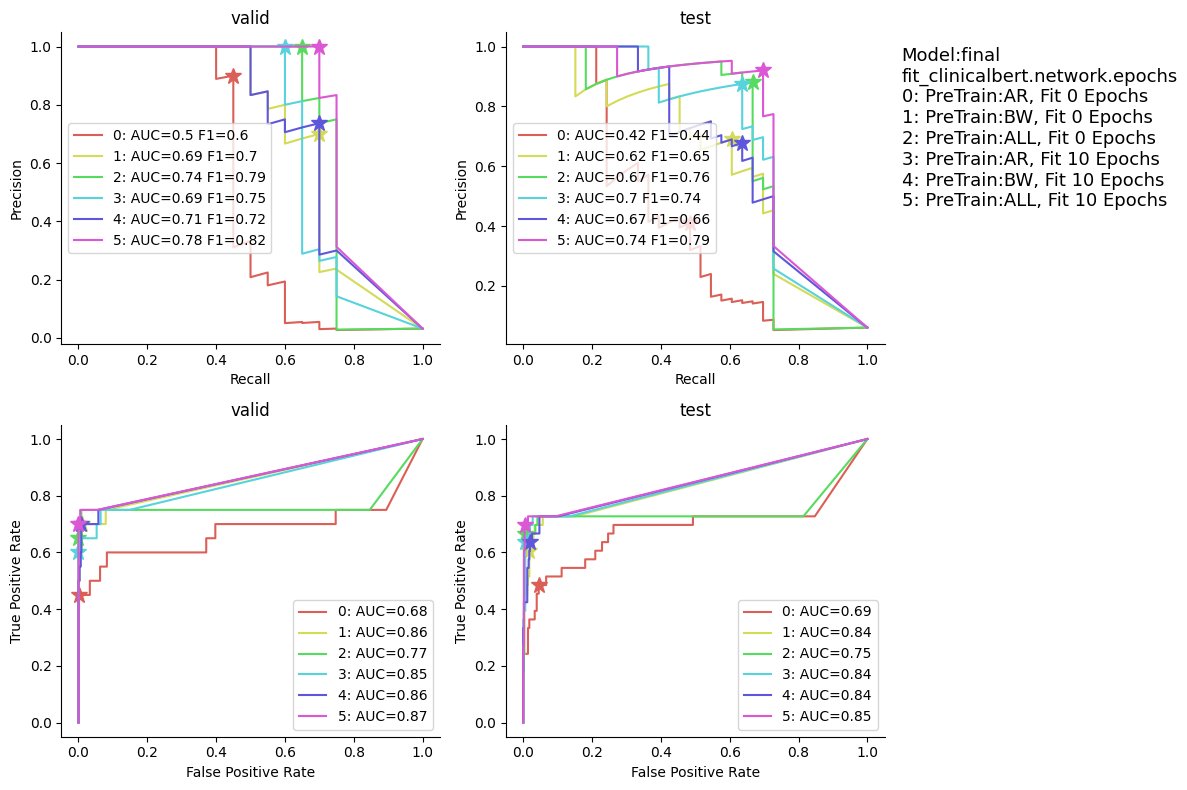

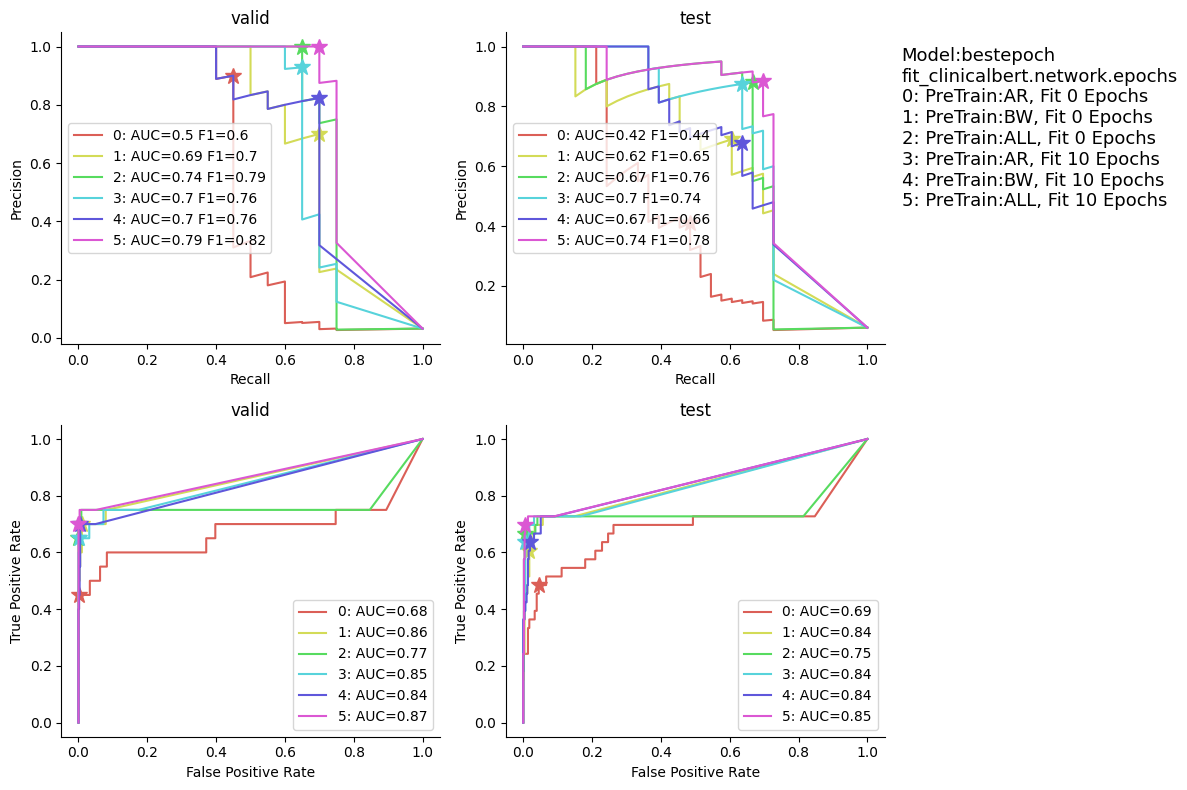

In [5]:
perfdata = defaultdict(lambda: defaultdict(list))

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,"PreTrain:AR, Fit 0 Epochs",0.900,0.45,0.600,0.495,0.678,0.410,0.485,0.444,0.416,0.687
1,"PreTrain:BW, Fit 0 Epochs",0.700,0.70,0.700,0.695,0.860,0.690,0.606,0.645,0.620,0.835
2,"PreTrain:ALL, Fit 0 Epochs",1.000,0.65,0.788,0.736,0.769,0.880,0.667,0.759,0.674,0.749
3,"PreTrain:AR, Fit 10 Epochs",0.929,0.65,0.765,0.699,0.848,0.875,0.636,0.737,0.697,0.838
4,"PreTrain:BW, Fit 10 Epochs",0.824,0.70,0.757,0.701,0.841,0.677,0.636,0.656,0.666,0.844
5,"PreTrain:ALL, Fit 10 Epochs",1.000,0.70,0.824,0.789,0.868,0.885,0.697,0.780,0.739,0.850


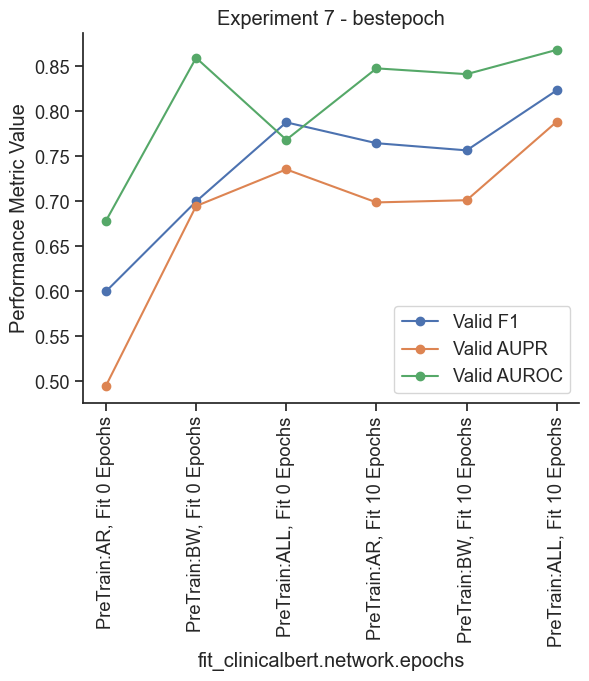

In [6]:
modeltype = 'bestepoch'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment 7 - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,"PreTrain:AR, Fit 0 Epochs",0.900,0.45,0.600,0.495,0.678,0.410,0.485,0.444,0.416,0.687
1,"PreTrain:BW, Fit 0 Epochs",0.700,0.70,0.700,0.695,0.860,0.690,0.606,0.645,0.620,0.835
2,"PreTrain:ALL, Fit 0 Epochs",1.000,0.65,0.788,0.736,0.769,0.880,0.667,0.759,0.674,0.749
3,"PreTrain:AR, Fit 10 Epochs",1.000,0.60,0.750,0.691,0.850,0.875,0.636,0.737,0.703,0.842
4,"PreTrain:BW, Fit 10 Epochs",0.737,0.70,0.718,0.707,0.864,0.677,0.636,0.656,0.668,0.843
5,"PreTrain:ALL, Fit 10 Epochs",1.000,0.70,0.824,0.784,0.868,0.920,0.697,0.793,0.744,0.849


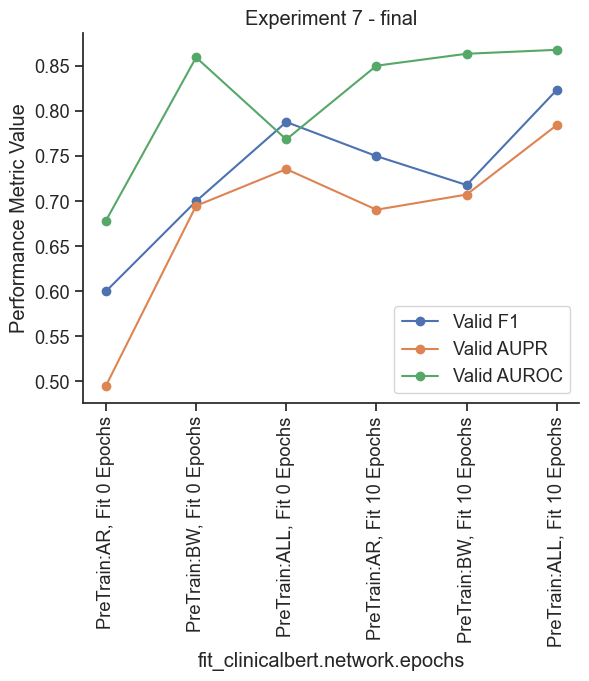

In [7]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment 7 - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)